## Implementação da validação cruzada para avaliação de modelos

### Introdução

Nosso principal objetivo neste trabalho é apresentar a implementação da validação cruzada para avaliação de modelos de classificação. O modelo aqui empregado é o k-nearest neighbors (KNN), utilizado para classificar o dataset Pima Indian Diabetes. Este conjunto de dados possui 768 instâncias, sendo 500 da classe negativa (não possui diabetes) e 268 da classe positiva (possui diabetes).

### Pré-requisitos

Optamos em desenvolver o trabalho usando Python 3, Notebook Jupyter e algumas outras bibliotecas com o objetivo de deixar o desenvolvimento mais simples. Abaixo é possível observar todas as bibliotecas utilizadas.

In [1]:
# importando bibliotecas
import pandas as pd
from csv import reader
from random import seed
from random import randrange
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

### Preparação dos dados

In [2]:
# Realizando uma leitura simples do arquivo
diabetes = pd.read_csv('diabetes.csv')

# criando um dataset organizado 
def load_csv():
    dataset = list()
    with open('diabetes.csv', 'r') as file:
        csv_reader = reader(file)
        next(csv_reader) # ignorando o cabeçalho
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset
dataset = load_csv()

# Apresentaodno cinco primeiras linhas do conjunto de dados original
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# obtendo algumas informações sobre dados ausentes ou nulos
diabetes.isna().sum()
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Com o resultado acima, conseguimos observar que não existem dados ausentes ou nulos. Entretanto, como mostra o histograma abaixo, conseguimos observar que existem outliers inesperados. Como por exemplo pressão arterial que em algumas amostras está com o valor zero. Sendo assim, precisamos realizar uma normalização/limpeza sobre os dados.

Casos de amostras da pressão arterial com valor zero: 35
Casos de amostras da Esp. da dobra cutânea com valor zero: 227


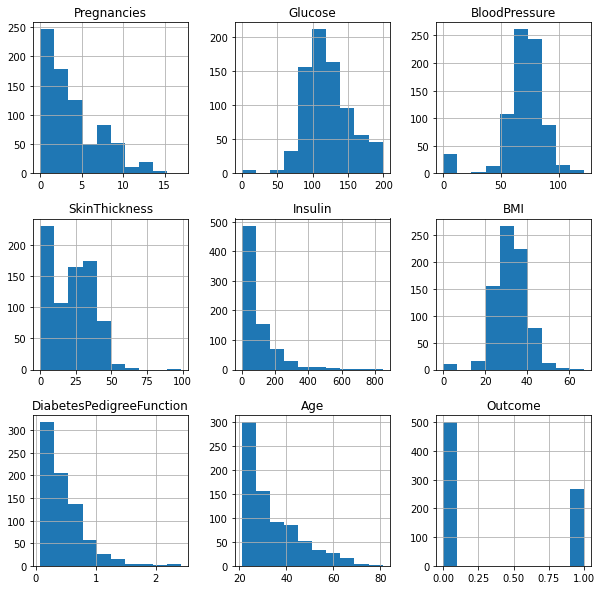

In [4]:
# histograma
diabetes.hist(figsize=(10, 10))

print('Casos de amostras da pressão arterial com valor zero:', diabetes[diabetes.BloodPressure == 0].shape[0])
print('Casos de amostras da Esp. da dobra cutânea com valor zero:', diabetes[diabetes.SkinThickness == 0].shape[0])

Nossa primeira modificação sobre os dados é sobre a coluna espessura da pele (SkinThickness). Como é possível observar no histograma acima, existem alguns casos com valores zero, sabemos também que diabetes não tem relação direta com a espessura da pele. Nesse sentido, nossa decisão foi remover a coluna.



In [5]:

# observamos que existem algunas casos com valores zero
# em um modo geral, caos de diabetes não tem uma relação direta com 

In [6]:
matrix = list()
accuracy = list()
recall = list()
precision = list()
score = list()

# convertendo os valores para números
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        classification_report(actual, predicted) # criando relatórios de métricas 
     
# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors
 
# Make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

def k_nearest_neighbors(train, test, num_neighbors):
    predictions = list()
    for row in test:
        output = predict_classification(train, row, num_neighbors)
        predictions.append(output)
    return(predictions)


def get_confusion_matrix(reais, preditos):
    # considerando a primeira classe como a positiva, e a segunda a negativa
    true_class = 1
    negative_class = 0
    # valores preditos corretamente
    tp = 0
    tn = 0
    # valores preditos incorretamente
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]
        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
            
            
    accuracy.append((tp+tn)/(fp+fn))
    recall.append(tp/(tp+fn))
    precision.append(tp/(tp+fp))
    score.append(2*tp/(2*tp+fp+fn))
    
    
    return np.array([
        # valores da classe positiva
        [ tp, fp ],
        # valores da classe negativa
        [ fn, tn ]
    ])

def classification_report(actual, predicted):
    print(get_confusion_matrix(actual, predicted))

dataset = load_csv()
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
n_folds = 5
num_neighbors = 5
evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors)

print(matrix)

data = {'Acurácia':accuracy, 'Recall': recall, 'Precisão':precision, 'f-score':score}
print(pd.DataFrame(data))
print('')
print('Média da acurácia: %.3f%%' % (sum(accuracy)/float(len(accuracy))))
print('Média da Recall: %.3f%%' % (sum(recall)/float(len(recall))))
print('Média da Precisão: %.3f%%' % (sum(precision)/float(len(precision))))
print('Média da f-score: %.3f%%' % (sum(score)/float(len(score))))
print("Desvio padrão da acurácia: {:.2f}%".format(np.std(accuracy)*100))
print("Desvio padrão da Recall: {:.2f}%".format(np.std(recall)*100))
print("Desvio padrão da Precisão: {:.2f}%".format(np.std(precision)*100))
print("Desvio padrão da f-score: {:.2f}%".format(np.std(score)*100))

[[34 21]
 [23 75]]
[[26 29]
 [16 82]]
[[27 32]
 [19 75]]
[[29 26]
 [21 77]]
[[26 18]
 [21 88]]
[]
   Acurácia    Recall  Precisão   f-score
0  2.477273  0.596491  0.618182  0.607143
1  2.400000  0.619048  0.472727  0.536082
2  2.000000  0.586957  0.457627  0.514286
3  2.255319  0.580000  0.527273  0.552381
4  2.923077  0.553191  0.590909  0.571429

Média da acurácia: 2.411%
Média da Recall: 0.587%
Média da Precisão: 0.533%
Média da f-score: 0.556%
Desvio padrão da acurácia: 30.33%
Desvio padrão da Recall: 2.15%
Desvio padrão da Precisão: 6.32%
Desvio padrão da f-score: 3.16%
